# Task A: Data Preprocessing

## 1. Preprocess the label file of MRI dataset

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

In [2]:
# Read label (.csv file) of dataset.
label_csv = pd.read_csv('.\dataset\label.csv')

# Print basic information of label, notice that it contains 4 classes based on tumor type. 
print(label_csv.info(), '\n')
print(label_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  3000 non-null   object
 1   label      3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB
None 

        file_name             label
0  IMAGE_0000.jpg  meningioma_tumor
1  IMAGE_0001.jpg          no_tumor
2  IMAGE_0002.jpg  meningioma_tumor
3  IMAGE_0003.jpg      glioma_tumor
4  IMAGE_0004.jpg  meningioma_tumor


In [3]:
# For binary task classification, we simply use "0" and "1" to indicate and identify whether there is a tumor in the MRI images. 
label_csv['new'] = 1
label_csv['new'][label_csv['label']=='no_tumor'] = 0

# Check result.
label_csv.head()

C:\Users\16967\.conda\envs\AMLS_Lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,file_name,label,new
0,IMAGE_0000.jpg,meningioma_tumor,1
1,IMAGE_0001.jpg,no_tumor,0
2,IMAGE_0002.jpg,meningioma_tumor,1
3,IMAGE_0003.jpg,glioma_tumor,1
4,IMAGE_0004.jpg,meningioma_tumor,1


In [4]:
# Transfer label into array dataformat.
label_TaskA = np.array(label_csv['new']).astype('uint8')

# Check result.
label_TaskA.shape, label_TaskA.dtype

((3000,), dtype('uint8'))

## 2. Preprocess MRI images

In [5]:
# Import necessary libraries
import cv2
from glob import glob

In [6]:
# Read 3000 512x512 pixel gray-scale MRI images
images = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) 
          for image in glob('dataset/image/*.jpg')]


## Uncomment the following code to check MRI image
# cv2.imshow('MRI Image Test', images[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [7]:
# Median filter is used to remove noise from the MRI images. 
images_blur = [cv2.medianBlur(images[i], 5)
               for i in range(0, len(images))]


# ## Uncomment the following code to check filtered MRI image.
# cv2.imshow('MRI Image After Median Filter Test', images_blur[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [8]:
# Enhance the contrast of the picture.
alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)
images_adjusted = [cv2.convertScaleAbs(images_blur[i], alpha=alpha, beta=beta)
                   for i in range(0, len(images))]

# Normalize pictures by using Maximum and minimum normalization.
images_normlize = [cv2.normalize(images_adjusted[i], None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) 
                   for i in range(0, len(images))]


# ## Uncomment the following code to check MRI image after enhancement.
# cv2.imshow('MRI Image After Median Filter Test', images_adjusted[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [9]:
# Resize images into 128*128 pixel
resize = 128
images_resized = [cv2.resize(images_normlize[i], (resize,resize))
                  for i in range(0, len(images))]

# Transfer images into array dataformat
images_TaskA = np.array(images_resized)

# Print image infotmation
print('{} images with {}x{} pixel. \n'.format(images_TaskA.shape[0], 
                                              images_TaskA.shape[1], 
                                              images_TaskA.shape[2]))

# Vectorize images.
images_TaskA = images_TaskA.reshape((3000, resize*resize))

# Print vectorized image information
print('After vectorization')
print('{} vectorized images with {}(512^2) pixel.'.format(images_TaskA.shape[0], 
                                                          images_TaskA.shape[1]))

3000 images with 128x128 pixel. 

After vectorization
3000 vectorized images with 16384(512^2) pixel.


## 3. Data dimensionality reduction and denoising by using PCA

### A simple verification: SVM without PCA

In [17]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [22]:
# Split data into a training set and a test set (90% training and 10% testing data).
# Notice that all random state is chosen as fixed in this assignment to ensure reproducibility.
X_train, X_test, y_train, y_test = train_test_split(images_TaskA,label_TaskA, 
                                                    test_size=0.1, random_state=0)

# Check result.
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((2700, 16384), (2700,), (300, 16384), (300,))

In [23]:
# Call the SVC() model from sklearn and fit the model to the training data.
svm_test = SVC()
svm_test.fit(X_train, y_train)

SVC()

In [24]:
# Get predictions from the model.
pred_test = svm_test.predict(X_test)

# Check the accuracy score.
print('Accuracy score:', accuracy_score(y_test,pred_test))

Accuracy score: 0.9166666666666666


### Implement PCA to reduce dimension of dataset

In [25]:
# Import necessary libraries
from sklearn.decomposition import PCA

In [26]:
# Call the PCA() model from sklearn and fit the model to the data without PCA.
# In this example, we want to oberserve the top 500 principal components of data.
pca_test = PCA(n_components=500)
pca_test.fit(images_TaskA)

PCA(n_components=500)

Text(0, 0.5, 'Loss')

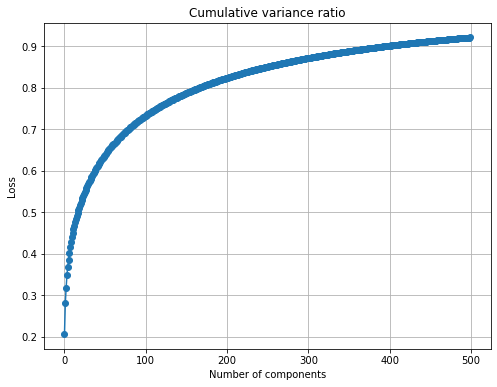

In [27]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Compute cumulative variance ratio of first 500 principle components.
n_components = 500
variance_ratio = pca_test.explained_variance_ratio_
variance_ratio_cum = variance_ratio.cumsum()

# Plot cumulative variance ratio of first 500 principle components.
plt.figure(figsize=(8,6))
plt.grid()   
    
plt.plot(variance_ratio_cum[:n_components], 'o-')
plt.title('Cumulative variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Loss')

### A simple verification: SVM with PCA

In [28]:
# Call the PCA() model from sklearn and fit the model to the training data.
# Notice that number of components is chosen as 200, since they contain more than 80% of information.
pca_TaskA = PCA(n_components=200)
images_PCA = pca_TaskA.fit_transform(images_TaskA)


# Split data into a training set and a test set (90% training and 10% testing data).
# Notice that all random state is chosen as fixed in this assignment to ensure reproducibility.
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(images_PCA,label_TaskA, 
                                                                    test_size=0.1, random_state=0)

# Check result.
print(X_train_PCA.shape, y_train_PCA.shape, X_test_PCA.shape, y_test_PCA.shape) 
print('train set: {}  | test set: {}'.format(round(len(y_train_PCA)/len(images_PCA),3), 
                                             round(len(y_test_PCA)/len(images_PCA),3)))

(2700, 200) (2700,) (300, 200) (300,)
train set: 0.9  | test set: 0.1


In [29]:
# Call the SVC() model from sklearn and fit the model to the training data after PCA.
svm_PCA = SVC()
svm_PCA.fit(X_train_PCA, y_train_PCA)

# Get predictions from the model.
pred_PCA = svm_PCA.predict(X_test_PCA)

# Check the accuracy score.
print('Accuracy score:', accuracy_score(y_test_PCA,pred_PCA))

Accuracy score: 0.9333333333333333


## 4. Save preprocessed data

In [30]:
# Import necessary libraries
import pickle

In [31]:
# Generate new data array of preprocessed data.
images_AfterProcess = images_PCA.copy()
label_AfterProcess = label_TaskA.copy()

# Check preprocessed data.
images_AfterProcess.shape, label_AfterProcess.shape

((3000, 200), (3000,))

In [32]:
# Save PCA model trained with 3000 MRI images.
with open('Model/DataProcess_PCA.pickle', 'wb') as handle:
    pickle.dump(pca_TaskA, handle)

# Save preprocessed data with help of pickle.
with open('DataAfterProcess/images_AfterProcess.pickle', 'wb') as handle:
    pickle.dump(images_AfterProcess, handle)
    
with open('DataAfterProcess/label_AfterProcess.pickle', 'wb') as handle:
    pickle.dump(label_AfterProcess, handle)